In [ ]:
!pip install shap
!pip install tensorflow_hub


In [ ]:
from tensorflow.keras.models import load_model
import tensorflow as tf
import numpy as np
import h5py
import shap
import tensorflow_hub as hub

import tensorflow as tf
import numpy as np
import h5py
import shap
import tensorflow_hub as hub
from skimage.segmentation import slic
from skimage.data import astronaut
from skimage import io

In [ ]:
"""============Prepare the DATA=========="""

def preprocess_image(image):
    """
    Preprocess images: resize and normalize.
    """
    image = tf.image.resize(image, [224, 224])
    image /= 255.0  # Normalize to [0,1] range
    return image

def prepare_dataset(image_file_path, label_file_path, batch_size=1, preprocess_fn=preprocess_image):
    """
    Load image and label data from HDF5 files and prepare a TensorFlow dataset.
    """
    with h5py.File(image_file_path, 'r') as f:
        images = f['x'][:]  #you can adjust the numbre of the image for your training here (depending on your ressource)
    with h5py.File(label_file_path, 'r') as f:
        labels = f['y'][:]  #you can adjust the numbre of the image for your training here (depending on your ressource)

    images = images.astype('float32')
    images = np.array([preprocess_fn(image) for image in images])
    labels = labels.astype('float32').reshape((-1, 1))

    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    dataset = dataset.batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset




In [ ]:
"""============model setup=========="""


model_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"
model = tf.keras.Sequential([
    hub.KerasLayer(model_url, input_shape=(224, 224, 3), trainable=True),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

print("Model input shape:", model.input_shape)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Prepare datasets
batch_size = 32
dataset_path = '/...' #path to your Dataset here
train_dataset = prepare_dataset(dataset_path + 'camelyonpatch_level_2_split_train_x.h5/',
                              dataset_path + 'camelyonpatch_level_2_split_valid_x.h5/',
                              batch_size=batch_size)
val_dataset=prepare_dataset(dataset_path + 'camelyonpatch_level_2_split_valid_x.h5/',
                              dataset_path + 'camelyonpatch_level_2_split_valid_y.h5/',
                              batch_size=batch_size)



In [ ]:
"""============ Train the model =========="""

epoch=30  #Adjust the number of epoch here
model.fit(train_dataset, validation_data=val_dataset, epochs=epoch)
model_save_path = '/.../model.h5'#path to save your model
model.save(model_save_path)

In [ ]:
"""=====Shape Setup ==="""

model = load_model('/..../model.h5', custom_objects={'KerasLayer': hub.KerasLayer}) #load the model


#SHAP analysis
background = np.stack([x[0].numpy() for x in val_dataset.unbatch().take(100)])
val_images, _ = next(iter(val_dataset.unbatch().batch(10)))
val_images = val_images.numpy()

# Initialize SHAP explainer
func_model = tf.keras.Model(inputs=model.inputs, outputs=model.outputs)
explainer = shap.GradientExplainer(func_model, background)

# Compute SHAP values
shap_values = explainer.shap_values(val_images)

num_superpixels = 200  # Define the number of superpixels here




<ipython-input-89-f226f4320256>:54: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.2, 0, 0.9, 1])


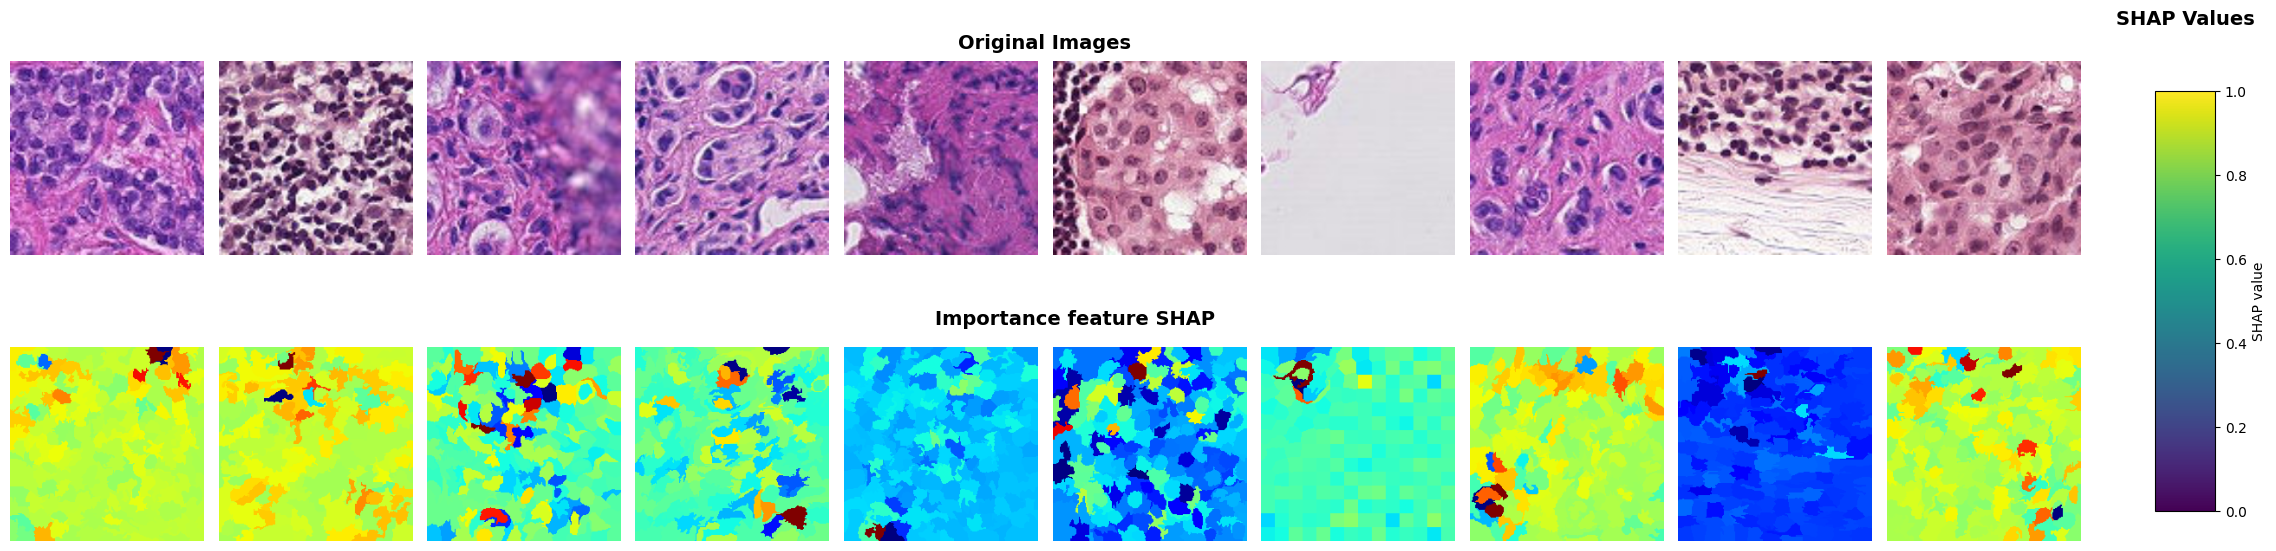

In [89]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import slic
from matplotlib.colors import ListedColormap

num_samples = 10 # Number of sample images to plot


fig, axs = plt.subplots(2, num_samples, figsize=(num_samples * 3, 6))

fig.text(0.55, 0.93, 'Original Images', ha='center', va='center', fontsize=14, fontweight='bold')
fig.text(0.56, 0.47, 'Importance feature SHAP', ha='center', va='center', fontsize=14, fontweight='bold')
fig.text(0.93, 0.97, 'SHAP Values', ha='center', va='center', fontsize=14, fontweight='bold')
for i in range(num_samples):
    # Original image
    image = val_images[i]
    axs[0, i].imshow(image)
    axs[0, i].axis('off')

    # SHAP values image
    shap_value = shap_values[i]

    # Generate superpixels for the image
    superpixels = slic(image, n_segments=num_superpixels, compactness=10, start_label=0) #we use the Slic as the clustering algorithm for the superpixels

    # Calculate SHAP values for superpixels
    shap_value_reshaped = shap_value.sum(axis=-1)  # Summing over the color channels
    superpixel_shap_values = np.array([shap_value_reshaped[superpixels == j].mean() for j in np.unique(superpixels)])

    # Normalize the SHAP values for better visualization
    superpixel_shap_values -= superpixel_shap_values.min()
    superpixel_shap_values /= superpixel_shap_values.ptp()

    # Create a color map for visualization of SHAP values
    shap_image = np.zeros_like(superpixels, dtype=float)
    for (label, value) in zip(np.unique(superpixels), superpixel_shap_values):
        shap_image[superpixels == label] = value


    cmap = plt.get_cmap('jet')
    colorful_shap_image = cmap(shap_image)
    shap_image_colored = cmap(shap_image)
    im = axs[1, i].imshow(shap_image_colored)
    axs[1, i].axis('off')

# Colorbar for SHAP values
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
norm = plt.Normalize(vmin=shap_image.min(), vmax=shap_image.max())
sm = plt.cm.ScalarMappable(cmap='jet', norm=norm)
sm.set_array([])
fig.colorbar(sm, cax=cbar_ax)
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label('SHAP value')
plt.tight_layout(rect=[0.2, 0, 0.9, 1])
plt.show()

<ipython-input-91-734e3ee4b3a5>:54: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.2, 0, 0.9, 1])


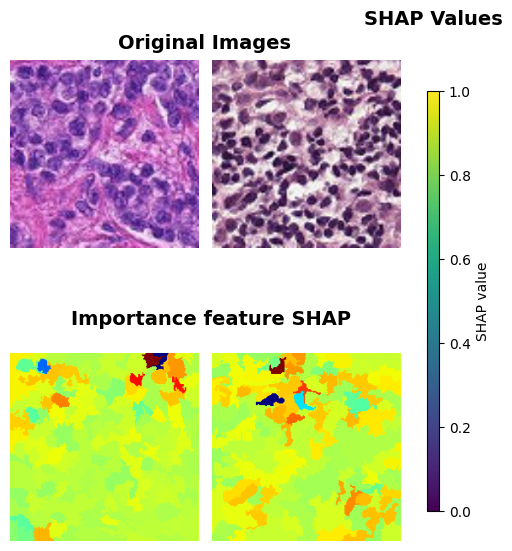

In [91]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import slic
from matplotlib.colors import ListedColormap

num_samples = 2  # Number of sample images to plot


fig, axs = plt.subplots(2, num_samples, figsize=(num_samples * 3, 6))

fig.text(0.55, 0.93, 'Original Images', ha='center', va='center', fontsize=14, fontweight='bold')
fig.text(0.56, 0.47, 'Importance feature SHAP', ha='center', va='center', fontsize=14, fontweight='bold')
fig.text(0.93, 0.97, 'SHAP Values', ha='center', va='center', fontsize=14, fontweight='bold')
for i in range(num_samples):
    # Original image
    image = val_images[i]
    axs[0, i].imshow(image)
    axs[0, i].axis('off')

    # SHAP values image
    shap_value = shap_values[i]

    # Generate superpixels for the image
    superpixels = slic(image, n_segments=num_superpixels, compactness=10, start_label=0) #we use the Slic as the clustering algorithm for the superpixels

    # Calculate SHAP values for superpixels
    shap_value_reshaped = shap_value.sum(axis=-1)  # Summing over the color channels
    superpixel_shap_values = np.array([shap_value_reshaped[superpixels == j].mean() for j in np.unique(superpixels)])

    # Normalize the SHAP values for better visualization
    superpixel_shap_values -= superpixel_shap_values.min()
    superpixel_shap_values /= superpixel_shap_values.ptp()

    # Create a color map for visualization of SHAP values
    shap_image = np.zeros_like(superpixels, dtype=float)
    for (label, value) in zip(np.unique(superpixels), superpixel_shap_values):
        shap_image[superpixels == label] = value


    cmap = plt.get_cmap('jet')
    colorful_shap_image = cmap(shap_image)
    shap_image_colored = cmap(shap_image)
    axs[1, i].imshow(shap_image_colored)
    axs[1, i].axis('off')

# Colorbar for SHAP values
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
norm = plt.Normalize(vmin=shap_image.min(), vmax=shap_image.max())
sm = plt.cm.ScalarMappable(cmap='jet', norm=norm)
sm.set_array([])
fig.colorbar(sm, cax=cbar_ax)
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label('SHAP value')
plt.tight_layout(rect=[0.2, 0, 0.9, 1])
plt.show()